In [6]:
print("Hello World!")

import re
import random
from sklearn.model_selection import train_test_split
import spacy
import fasttext.util
import gensim
import functools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from gensim.models import FastText
import pickle
import os
import gc
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

DATA_DIR = '/kaggle/input/anlp-language-modelling/'

VAL_SPLIT = 0.2
TEST_SPLIT = 0.1

print("Imports done")

Hello World!
cuda
Imports done


In [7]:
class FastTextEmbeddingGenerator:
    def __init__(self):
        self.model = None

    def set_model(self, model):
        self.model = model
    
    def get_embedding(self, word):
        if word in self.model:
            embedding = self.model[word]
            return embedding
        else:
            embedding = self.model.get_word_vector(word)
            return embedding
        

fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')
embedding_gen = FastTextEmbeddingGenerator()
embedding_gen.set_model(ft)

print("FastText model loaded")

FastText model loaded


In [8]:
class LanguageModelDataset:
    def __init__(self, file_path, chunk_size=100000):
        self.file_path = file_path
        self.chunk_size = chunk_size
        self.nlp = spacy.load("en_core_web_sm", disable=["ner"])
        self.sentences = self._process_large_file()
        self.train_sentences = None
        self.val_sentences = None
        self.test_sentences = None
        # self.max_sentence_length = max(len(sentence.split()) for sentence in self.sentences)  # Calculate global max sentence length
        self.max_sentence_length = 80  # Calculate global max sentence length

    # @functools.lru_cache(maxsize=None)
    def _process_large_file(self):
        sentences = []
        c = 0
        with open(self.file_path, 'r', encoding='utf-8') as file:
            buffer = ""
            for line in file:

#                 if c > 100:
#                     break

                line = line.strip()
                if line: 

                    if buffer:
                        buffer += " " + line
                    else:
                        buffer = line

                else: 

                    if buffer:
                        temp_sentences = buffer.split(".")
                        for sentence in temp_sentences:
                            sentence = sentence.strip()
                            sentence = re.sub(r"[^a-zA-Z0-9\s]+", '', sentence)
                            sentence = sentence.strip()
                            # preprocess text
                            preprocessed_text = self._preprocess_text(sentence)
                            if preprocessed_text:
                                c += 1
                                sentences.append(preprocessed_text)

                        buffer = ""

            if buffer:
                buffer = buffer.strip()
                buffer = re.sub(r"[^a-zA-Z0-9\s]+", '', buffer)
                temp_sentences = buffer.split(".")
                for sentence in temp_sentences:
                    sentence = sentence.strip()
                    preprocessed_text = self._preprocess_text(sentence)
                    if preprocessed_text:
                        sentences.append(preprocessed_text)
                # sentences.append(self._preprocess_text(buffer))

        # sentences = [sentence for sentence in sentences if sentence != ""]
        return sentences

    # @functools.lru_cache(maxsize=None)
    def _preprocess_text(self, text):
        doc = self.nlp(text)
        sentences = " ".join([token.text for token in doc])
        return sentences

    # @functools.lru_cache(maxsize=None)
    def get_splits(self, val_size=10000, test_size=20000):
        train_sentences, val_test_sentences = train_test_split(self.sentences, test_size=val_size+test_size, shuffle=False, random_state=42)
        test_size = test_size / (val_size + test_size)
        val_sentences, test_sentences = train_test_split(val_test_sentences, test_size=test_size, shuffle=False, random_state=42)
        self.train_sentences = train_sentences
        self.val_sentences = val_sentences
        self.test_sentences = test_sentences
        return train_sentences, val_sentences, test_sentences
    
    def build_vocab(self):
        vocab = set()
        for sentence in self.train_sentences:
            for word in sentence.split():
                vocab.add(word)
        self.vocab = list(vocab)
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

file_path = DATA_DIR + 'Auguste_Maquet.txt'
dataset = LanguageModelDataset(file_path)
print(f"Total number of sentences: {len(dataset.sentences)}")
train_sentences, val_sentences, test_sentences = dataset.get_splits(val_size=VAL_SPLIT, test_size=TEST_SPLIT)


Total number of sentences: 55298


In [9]:
print(f"Length of train_sentences: {len(train_sentences)}")
print(f"Length of val_sentences: {len(val_sentences)}")
print(f"Length of test_sentences: {len(test_sentences)}")

dataset.build_vocab() # Build vocabulary

word2idx = dataset.word2idx
idx2word = dataset.idx2word

# add UNK token
word2idx['<UNK>'] = len(word2idx)
idx2word[len(idx2word)] = '<UNK>'
dataset.vocab.append('<UNK>')

# add PAD token
word2idx['<PAD>'] = len(word2idx)
idx2word[len(idx2word)] = '<PAD>'
dataset.vocab.append('<PAD>')

vocab_size = len(word2idx)

print(f"Number of training sentences: {len(train_sentences)}")

Length of train_sentences: 38708
Length of val_sentences: 11060
Length of test_sentences: 5530
Number of training sentences: 38708


In [10]:
from tqdm import tqdm

def extract_data(sentences, word2idx, embedding_gen, n_gram=5):
    inputs, targets = [], []

    for sentence in tqdm(sentences, desc="Processing Sentences"):
        try:
            words = sentence.split()

            # Precompute embeddings for all words in the sentence
            embeddings = np.array([embedding_gen.get_embedding(word) for word in words], dtype=np.float32)
            embeddings = torch.tensor(embeddings, dtype=torch.float32)
            embeddings.to(device)
            
            # Create sliding windows of 5-gram context
            for i in range(len(words) - n_gram):
                context_embeddings = embeddings[i:i+n_gram].view(-1)  # Flatten the 5-gram embeddings
                inputs.append(context_embeddings)
                
                target_word = words[i + n_gram]

                if target_word in word2idx:
                    target_idx = word2idx[target_word]
                else:
                    target_idx = word2idx['<UNK>']

                targets.append(target_idx)

        except Exception as e:
            print(f"Error processing sentence: {sentence}")
            print(e)
            continue

    inputs = torch.stack(inputs)
    targets = torch.tensor(targets).to(device)
    return inputs, targets

# Exclude the sentences that are shorter than 5 words
train_sentences = [sentence for sentence in train_sentences if len(sentence.split()) > 5]

train_inputs, train_targets = extract_data(train_sentences, word2idx, embedding_gen)

print(f"Train Inputs Shape: {train_inputs.shape}")
print(f"Train Targets Shape: {train_targets.shape}")

Processing Sentences: 100%|██████████| 31530/31530 [06:35<00:00, 79.62it/s] 


Train Inputs Shape: torch.Size([485508, 1500])
Train Targets Shape: torch.Size([485508])


In [11]:
torch.cuda.empty_cache()
gc.collect()

class NeuralLanguageModel(nn.Module):
    def __init__(self, n_gram, vocab_size, embedding_dim=300, hidden_dim=300, dropout=0.2):
        super(NeuralLanguageModel, self).__init__()
        self.fc1 = nn.Linear(embedding_dim * n_gram, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)  # Output is vocab size
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        # return self.softmax(x)

model = NeuralLanguageModel(n_gram=5, vocab_size=vocab_size, embedding_dim=300, hidden_dim=300)

print(f"Model initialized")

torch.cuda.empty_cache()
gc.collect()

Model initialized


8

In [12]:
val_sentences = [sentence for sentence in val_sentences if len(sentence.split()) > 5]
val_inputs, val_targets = extract_data(val_sentences, word2idx, embedding_gen)

print(f"Val Inputs Shape: {val_inputs.shape}")
print(f"Val Targets Shape: {val_targets.shape}")

torch.cuda.empty_cache()
gc.collect()

batch_size = 64
epochs = 10
learning_rate = 0.001

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # L2 regularization

print(f"Model moved to device")

Processing Sentences: 100%|██████████| 8991/8991 [01:52<00:00, 80.09it/s] 


Val Inputs Shape: torch.Size([133570, 1500])
Val Targets Shape: torch.Size([133570])
Model moved to device


In [13]:
def calculate_val_loss(model, val_inputs, val_targets, criterion):
    val_loss = 0
    model.eval()
    with torch.no_grad():
        pbar = tqdm(range(0, len(val_inputs), batch_size), desc="Validation Batches")
        for i in pbar:
            inputs = val_inputs[i:i+batch_size].to(device)
            targets = val_targets[i:i+batch_size].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            pbar.set_postfix({"Current Validation Loss": loss.item()})

    if len(val_inputs) < batch_size:
        val_loss /= 1
    else:
        val_loss /= (len(val_inputs)//batch_size)

    return val_loss

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0
    pbar = tqdm(range(0, len(train_inputs), batch_size), desc="Training Batches")
    for i in pbar:
        inputs = train_inputs[i:i+batch_size].to(device)
        targets = train_targets[i:i+batch_size].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({"Current Training Loss": loss.item()})
    
    train_loss = running_loss / (len(train_inputs)//batch_size)
    val_loss = calculate_val_loss(model, val_inputs, val_targets, criterion)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    torch.cuda.empty_cache()
    gc.collect()

print("Training complete")

Validation Batches: 100%|██████████| 2088/2088 [00:03<00:00, 590.36it/s, Current Validation Loss=4.09]


Epoch 1/10, Train Loss: 6.005507303359105, Val Loss: 5.8596308330742435


Validation Batches: 100%|██████████| 2088/2088 [00:03<00:00, 585.95it/s, Current Validation Loss=3.84]


Epoch 2/10, Train Loss: 5.582723828314981, Val Loss: 5.740901946907244


Validation Batches: 100%|██████████| 2088/2088 [00:03<00:00, 572.42it/s, Current Validation Loss=3.92]


Epoch 3/10, Train Loss: 5.4366643035628694, Val Loss: 5.688324459671803


Validation Batches: 100%|██████████| 2088/2088 [00:03<00:00, 585.85it/s, Current Validation Loss=3.84]


Epoch 4/10, Train Loss: 5.35553628471826, Val Loss: 5.664046059285389


Validation Batches: 100%|██████████| 2088/2088 [00:03<00:00, 582.52it/s, Current Validation Loss=3.94]


Epoch 5/10, Train Loss: 5.305482506217725, Val Loss: 5.656025100108477


Validation Batches: 100%|██████████| 2088/2088 [00:03<00:00, 578.35it/s, Current Validation Loss=4]   


Epoch 6/10, Train Loss: 5.265582886780594, Val Loss: 5.6462146862306035


Validation Batches: 100%|██████████| 2088/2088 [00:03<00:00, 576.80it/s, Current Validation Loss=4.1] 


Epoch 7/10, Train Loss: 5.239946722512882, Val Loss: 5.641084207892132


Validation Batches: 100%|██████████| 2088/2088 [00:03<00:00, 558.91it/s, Current Validation Loss=4]   


Epoch 8/10, Train Loss: 5.22057745210294, Val Loss: 5.627634191604454


Validation Batches: 100%|██████████| 2088/2088 [00:03<00:00, 583.76it/s, Current Validation Loss=4.23]


Epoch 9/10, Train Loss: 5.201268019602036, Val Loss: 5.616127024898702


Validation Batches: 100%|██████████| 2088/2088 [00:03<00:00, 589.20it/s, Current Validation Loss=4.2] 


Epoch 10/10, Train Loss: 5.186957204935892, Val Loss: 5.603860939183073
Training complete


In [14]:
torch.save(model, 'language_model_q1.pth')

torch.cuda.empty_cache()
gc.collect()

0

In [15]:
test_sentences = [sentence for sentence in test_sentences if len(sentence.split()) > 5]
test_inputs, test_targets = extract_data(test_sentences, word2idx, embedding_gen)

print(f"Test Inputs Shape: {test_inputs.shape}")
print(f"Test Targets Shape: {test_targets.shape}")

# Evaluate on test set

def calculate_test_loss(model, test_inputs, test_targets, criterion):
    test_loss = 0
    model.eval()
    with torch.no_grad():
        pbar = tqdm(range(0, len(test_inputs), batch_size), desc="Test Batches")
        for i in pbar:
            inputs = test_inputs[i:i+batch_size].to(device)
            targets = test_targets[i:i+batch_size].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            pbar.set_postfix({"Current Test Loss": loss.item()})
    
    # return test_loss / (len(test_inputs)//batch_size)

    if len(test_inputs) < batch_size:
        test_loss /= 1
    else:
        test_loss /= (len(test_inputs)//batch_size)

    return test_loss

test_loss = calculate_test_loss(model, test_inputs, test_targets, criterion)
print(f"Test Loss: {test_loss}")

torch.cuda.empty_cache()
gc.collect()

Processing Sentences: 100%|██████████| 4575/4575 [00:41<00:00, 111.23it/s]


Test Inputs Shape: torch.Size([66970, 1500])
Test Targets Shape: torch.Size([66970])


Test Batches: 100%|██████████| 1047/1047 [00:01<00:00, 544.37it/s, Current Test Loss=6.52]


Test Loss: 5.644802004155876


0

In [27]:
def calculate_perplexity(model, sentence, word2idx, embedding_gen, criterion):
    model.eval()
    words = sentence.split()
    # embeddings = torch.tensor([embedding_gen.get_embedding(word) for word in words], dtype=torch.float32).to(device)
    embeddings = np.array([embedding_gen.get_embedding(word) for word in words], dtype=np.float32)
    embeddings = torch.tensor(embeddings, dtype=torch.float32).to(device)
    total_loss = 0
    with torch.no_grad():
        for i in range(len(words) - 5):
            context_embeddings = embeddings[i:i+5].view(-1)
            target_word = words[i+5]
            target_idx = word2idx.get(target_word, word2idx['<UNK>'])
            target = torch.tensor([target_idx]).to(device)
            context_embeddings = context_embeddings.unsqueeze(0)
            context_embeddings = context_embeddings.to(device)
            output = model(context_embeddings)
            loss = criterion(output, target)
            total_loss += loss.item()

    perplexity = np.exp(total_loss / (len(words) - 5))
    return perplexity

def compute_perplexity_average(model, sentences, word2idx, embedding_gen, criterion):
    print("Computing Average Perplexities")
    perplexities = []
    for sentence in tqdm(sentences):
        perplexity = calculate_perplexity(model, sentence, word2idx, embedding_gen, criterion)
        perplexities.append(perplexity)
    return np.mean(perplexities)

In [17]:
perplexities_train = []
perplexities_test = []

with open('perplexity_sentences_training_q1.txt', 'w') as file:
    for sentence in tqdm(train_sentences, desc="Processing Sentences"):
        perplexity = calculate_perplexity(model, sentence, word2idx, embedding_gen, criterion)
        perplexities_train.append(perplexity)
        file.write(f"{sentence}\t{perplexity}\n")

    file.write(f"Average Perplexity: {np.mean(perplexities_train)}")

torch.cuda.empty_cache()
gc.collect()

Processing Sentences: 100%|██████████| 31530/31530 [09:42<00:00, 54.16it/s] 


0

In [44]:
from scipy.stats import trim_mean
print(np.mean(perplexities_train))
print(np.mean(perplexities_test))
print('\n')
print(np.median(perplexities_train))
print(np.median(perplexities_test))
print('\n')
train_trimmed_mean = trim_mean(perplexities_train, proportiontocut=0.1)
print(f"Trimmed Mean: {train_trimmed_mean}")
test_trimmed_mean = trim_mean(perplexities_test, proportiontocut=0.1)
print(f"Trimmed Mean: {test_trimmed_mean}")

1425.65149132652
77008.05667643396


143.50080307735112
280.95614667330796


Trimmed Mean: 183.64588966077596
Trimmed Mean: 397.1183218496466


In [18]:
with open('perplexity_sentences_test_q1.txt', 'w') as file:
    for sentence in tqdm(test_sentences, desc="Processing Sentences"):
        perplexity = calculate_perplexity(model, sentence, word2idx, embedding_gen, criterion)
        perplexities_test.append(perplexity)
        file.write(f"{sentence}\t{perplexity}\n")

    file.write(f"Average Perplexity: {np.mean(perplexities_test)}")

torch.cuda.empty_cache()
gc.collect()

Processing Sentences: 100%|██████████| 4575/4575 [01:07<00:00, 68.13it/s] 


0

In [ ]:
def train_with_hyperparameters(dropout_rates, hidden_dims, optimizers, criterion, train_X, train_y, val_X, val_y, epochs=10, batch_size=64):
    results = []
    val_perplexities = []

    for dropout in dropout_rates:
        for hidden_dim in hidden_dims:
            for opt in optimizers:
                print("Starting for New Params")
                model = NeuralLanguageModel(n_gram=5, vocab_size=vocab_size, embedding_dim=300, hidden_dim=hidden_dim).to(device)
                if opt == optimizers[0]:
                    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
                else:
                    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)

                for epoch in range(epochs):
                    model.train()
                    for i in tqdm(range(0, len(train_X), batch_size), desc=f"Epoch {epoch+1}/{epochs}"):
                        inputs = train_X[i:i+batch_size].to(device)
                        targets = train_y[i:i+batch_size].to(device)
                        
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        loss.backward()
                        optimizer.step()
                
                print("Training Complete")
#                 train_perplexity = compute_perplexity_average(model, train_sentences, word2idx, embedding_gen, criterion)
                val_perplexity = compute_perplexity_average(model, val_sentences, word2idx, embedding_gen, criterion)
                
#                 train_perplexities.append(train_perplexity)
                val_perplexities.append(val_perplexity)
                print(f"Val Perplexity: {val_perplexity}")
                
                if opt == optimizers[0]:
                    results.append((dropout, hidden_dim, "Adam", val_perplexity))
                else:
                    results.append((dropout, hidden_dim, "SGD", val_perplexity))

                del model, optimizer, val_perplexity
                torch.cuda.empty_cache()
                gc.collect()
    
    return results

dropout_rates = [0.2, 0.3]
hidden_dims = [300, 400]
optimizers = [optim.Adam, optim.SGD]

results = train_with_hyperparameters(dropout_rates, hidden_dims, optimizers, criterion, train_inputs, train_targets, test_inputs, test_targets, epochs=5, batch_size=64)

print("Hyperparameter tuning complete")

In [ ]:
results_df = pd.DataFrame(results, columns=["Dropout", "Hidden Dim", "Optimizer", "Test Perplexity"])
results_df.to_csv('hyperparameter_results.csv', index=False)

print("Best Hyperparameters")
print(results_df.loc[results_df['Test Perplexity'].idxmin()])
print("Worst Hyperparameters")
print(results_df.loc[results_df['Test Perplexity'].idxmax()])

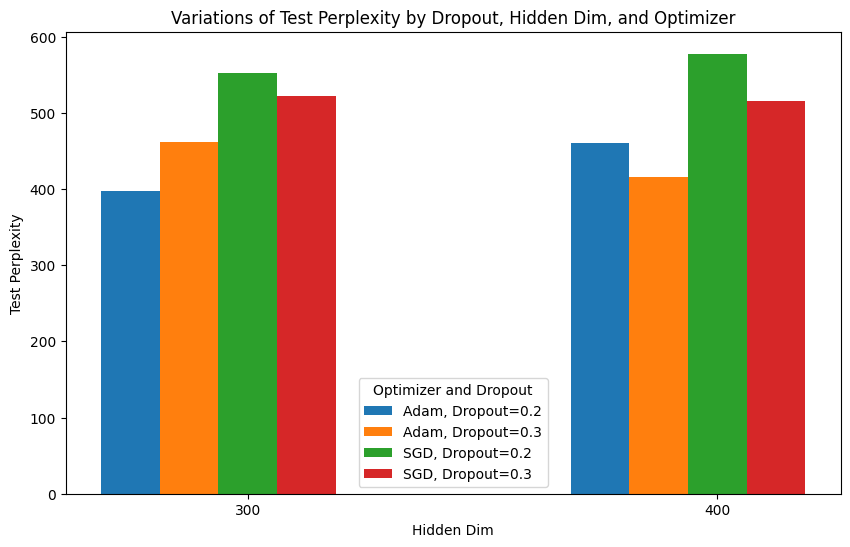

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

results_df = pd.read_csv('hyperparameter_results.csv')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define the positions for the bars
x = np.arange(len(results_df['Hidden Dim'].unique()))
width = 0.25

# Plot bars for each optimizer and dropout combination
for i, (optimizer, group) in enumerate(results_df.groupby('Optimizer')):
    for j, dropout in enumerate(group['Dropout'].unique()):
        data = group[group['Dropout'] == dropout]
        ax.bar(x + i * width + j * width / len(group['Dropout'].unique()), data['Test Perplexity'], width / len(group['Dropout'].unique()), label=f'{optimizer}, Dropout={dropout}')

# Set labels and title
ax.set_xlabel('Hidden Dim')
ax.set_ylabel('Test Perplexity')
ax.set_title('Variations of Test Perplexity by Dropout, Hidden Dim, and Optimizer')

# Set x-ticks and labels
ax.set_xticks(x + width)
ax.set_xticklabels(results_df['Hidden Dim'].unique())

# Add legend
ax.legend(title='Optimizer and Dropout')

plt.savefig('test_perplexity_plot.png')

# Show the plot
plt.show()

In [40]:
!ls /kaggle/working
from IPython.display import FileLink
display(FileLink('hyperparameter_results.csv'))

cc.en.300.bin		    perplexity_sentences_test_q1.txt
cc.en.300.bin.gz	    perplexity_sentences_training_q1.txt
hyperparameter_results.csv  state.db
language_model_q1.pth	    test_perplexity_plot.png


/kaggle/working/hyperparameter_results.csv